In [2]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from keras.models import load_model
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [3]:
# Classes Directories
NonViolnceVideos_Dir = r"F:\DSGP\Violence Detection\Dataset\Non-Violence"
ViolnceVideos_Dir = r"F:\DSGP\Violence Detection\Dataset\Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

**Play Random Non Violence Video**

In [6]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [8]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

# Extracting Frames

In [9]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
NUM_FRAMES = 16
 

DATASET_DIR = "F:\DSGP\Violence Detection\Dataset"
 
CLASSES_LIST = ["Non-Violence","Violence"]

OUTPUT_PATH = "F:\DSGP\Violence Detection\Data Frames/"

In [10]:
def frames_extraction(video_path):
 
    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/NUM_FRAMES), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(NUM_FRAMES):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
 
    print('Done ' + str(video_path))
    video_reader.release()
 
    return frames_list

# Creating the Data

In [11]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the NUM_FRAMES specified.
            # So ignore the vides having frames less than the NUM_FRAMES.
            if len(frames) == NUM_FRAMES:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [12]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Non-Violence
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv1.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv10.mp4
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv100.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv101.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv102.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv103.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv104.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv105.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv106.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv107.mov
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv108.mp4
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv109.mp4
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv11.mp4
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv110.mp4
Done F:\DSGP\Violence Detection\Dataset\Non-Violence\nv111.mp4
Done F:\DSGP\Violenc

In [13]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [14]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

# Encoding and Splitting Training-Testing Sets

In [15]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [16]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1, shuffle = True, random_state = 42)

In [17]:
print(features_train.shape,labels_train.shape)
print(features_test.shape, labels_test.shape)

(2220, 16, 64, 64, 3) (2220, 2)
(247, 16, 64, 64, 3) (247, 2)


# Importing MobileNet and Fine-Tuning it.

In [18]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
    layer.trainable=False

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

# Building The Model

In [19]:
def create_model():
 
    model = Sequential()
    
    #Specifying Input to match features shape
    model.add(Input(shape = (NUM_FRAMES, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    # BiLSTM layer
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    # Dense layers
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    model.summary()
    
    return model

In [20]:
# Constructing the Model
Violence_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(Violence_model, to_file = 'Violence_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 2, 2, 1280)   2257984   
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 5120)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               1319168   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

# Specifying Callbacks and Fitting

In [21]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
Violence_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
# Fitting the model 
Violence_model_history = Violence_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
222/222 [==============================] - 705s 3s/step - loss: 0.6983 - accuracy: 0.4966 - val_loss: 0.6920 - val_accuracy: 0.4910 - lr: 0.0100
Epoch 2/50
222/222 [==============================] - 618s 3s/step - loss: 0.6922 - accuracy: 0.5315 - val_loss: 0.6821 - val_accuracy: 0.5788 - lr: 0.0100
Epoch 3/50
222/222 [==============================] - 527s 2s/step - loss: 0.6572 - accuracy: 0.6030 - val_loss: 0.5805 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 4/50
222/222 [==============================] - 598s 3s/step - loss: 0.5716 - accuracy: 0.7202 - val_loss: 0.5002 - val_accuracy: 0.7703 - lr: 0.0100
Epoch 5/50
222/222 [==============================] - 576s 3s/step - loss: 0.4763 - accuracy: 0.8024 - val_loss: 0.4695 - val_accuracy: 0.7748 - lr: 0.0100
Epoch 6/50
222/222 [==============================] - 717s 3s/step - loss: 0.3953 - accuracy: 0.8452 - val_loss: 0.5563 - val_accuracy: 0.7613 - lr: 0.0100
Epoch 7/50
222/222 [==============================] - 748s 3s/st

In [22]:
Violence_model.save('violence-detection.h5', overwrite=True, include_optimizer=True)

In [23]:
model_evaluation_history = Violence_model.evaluate(features_test, labels_test)

8/8 [==============================] - 3s 407ms/step - loss: 0.5273 - accuracy: 0.9028


# Model Evaluation

In [24]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

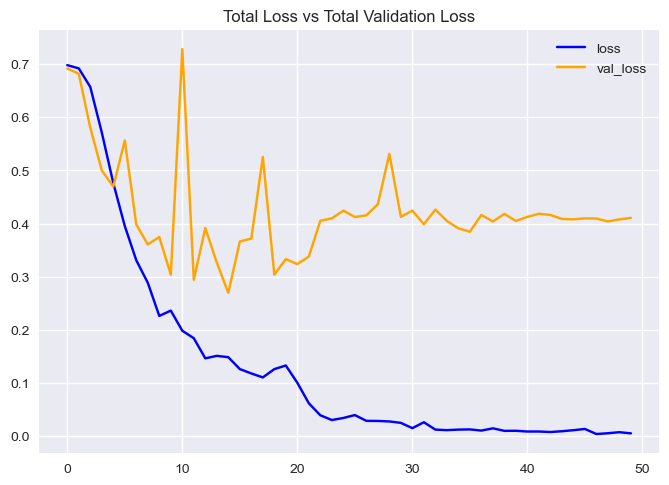

In [25]:
plot_metric(Violence_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

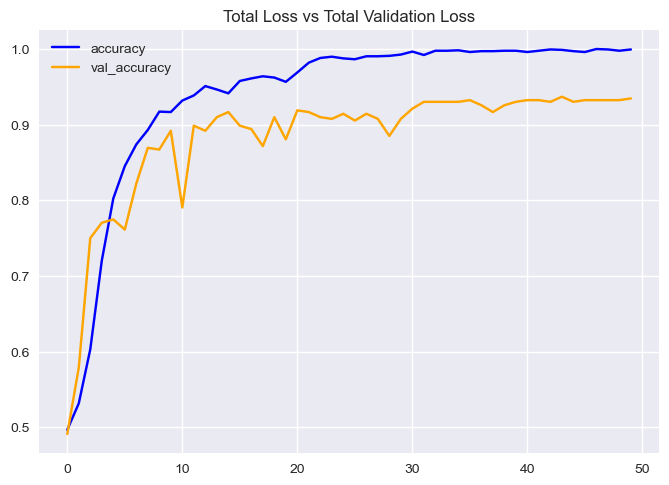

In [26]:
plot_metric(Violence_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

# Predicting the Test Set

In [27]:
labels_predict = Violence_model.predict(features_test)

8/8 [==============================] - 4s 393ms/step


In [28]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [29]:
labels_test_normal.shape , labels_predict.shape

((247,), (247,))

Accuracy Score

In [30]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.902834008097166


Confusion Matrix

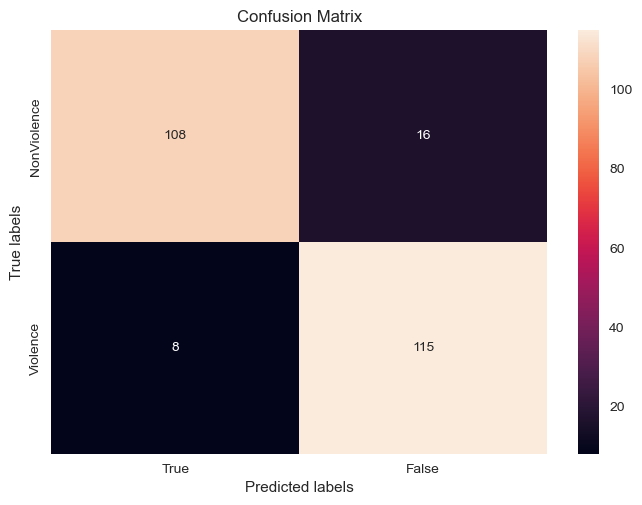

In [32]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

Classification Report

In [33]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90       124
           1       0.88      0.93      0.91       123

    accuracy                           0.90       247
   macro avg       0.90      0.90      0.90       247
weighted avg       0.90      0.90      0.90       247

